## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.   

## Dataset:   
The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
root='/content/drive/MyDrive/Upgrad/cnn_assignment'
print(os.getcwd())
os.chdir(root)
print(os.getcwd())

/content
/content/drive/MyDrive/Upgrad/cnn_assignment


In [3]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# import 
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import PIL
import Augmentor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [5]:
# set data path
data_dir_train = pathlib.Path("/content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
# Get the count of images 
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Total train images : {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Total test images  : {image_count_test}")

Total train images : 2239
Total test images  : 118


In [7]:
# check for class balance
classes=[]
count=[]
pct=[]

for d in os.listdir(data_dir_train):
    pth=pathlib.Path(os.path.join(data_dir_train,d))
    img_count=len(list(pth.glob('*.jpg')))
    pctg=round((img_count/image_count_train)*100,2)
    # print(f"{d}  : {img_count} | {pctg}%")
    classes.append(d)
    count.append(img_count)
    pct.append(pctg)

stats_df=pd.DataFrame(columns=['class','count','percentage'])
stats_df['class']=pd.Series(classes)
stats_df['count']=pd.Series(count)
stats_df['percentage']=pd.Series(pct)
classes=list(stats_df['class'])
stats_df

class  count  percentage
0           actinic keratosis    114        5.09
1        basal cell carcinoma    376       16.79
2              dermatofibroma     95        4.24
3                    melanoma    438       19.56
4                       nevus    357       15.94
5  pigmented benign keratosis    462       20.63
6        seborrheic keratosis     77        3.44
7     squamous cell carcinoma    181        8.08
8             vascular lesion    139        6.21

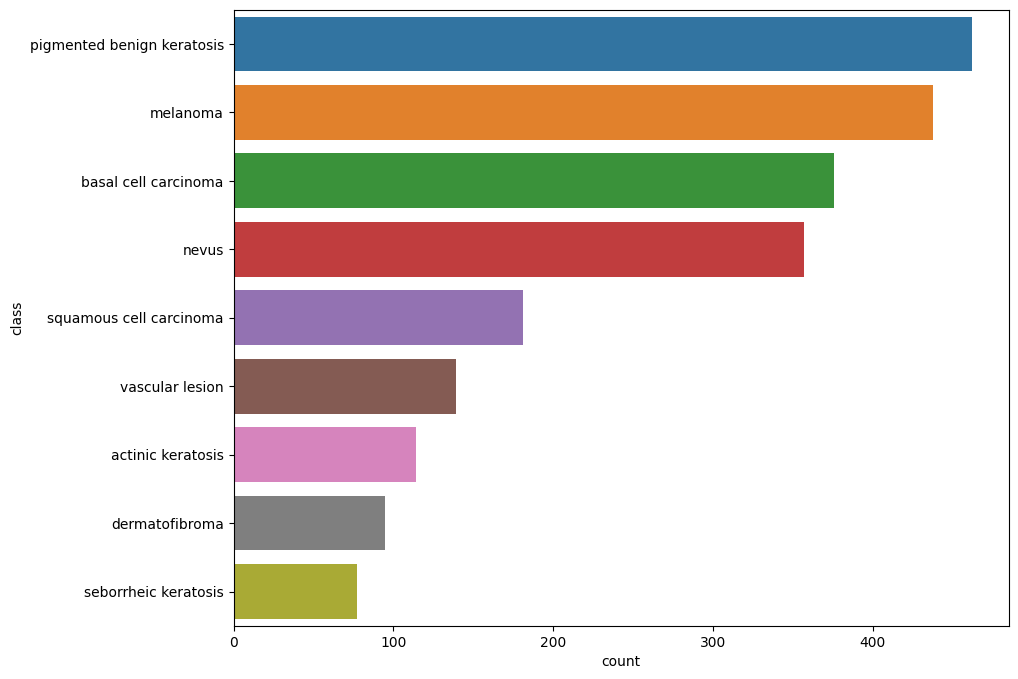

In [8]:
# plot the class balance
stats_df=stats_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x="count", y="class", data=stats_df, label="class")
plt.show()

From the above plot we can understand that there is a class imabalance in the dataset.  
seborrheic has only 77 samples (class with least number of samples) where as pigmented benign keratosis has 462 samples (class with highest number of samples)


In [9]:
# Get the count of images 
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Total train images : {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Total test images  : {image_count_test}")

Total train images : 2239
Total test images  : 118


### Load the data 

In [10]:
# creating training and validation data sets

batch_size = 32
img_height = 180
img_width = 180

# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               label_mode='categorical',
                                                               seed=123,
                                                               subset="training",
                                                               validation_split=0.2)


# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                            batch_size=batch_size,
                                                            image_size=(img_height,img_width),
                                                            label_mode='categorical',
                                                            seed=123,
                                                            subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


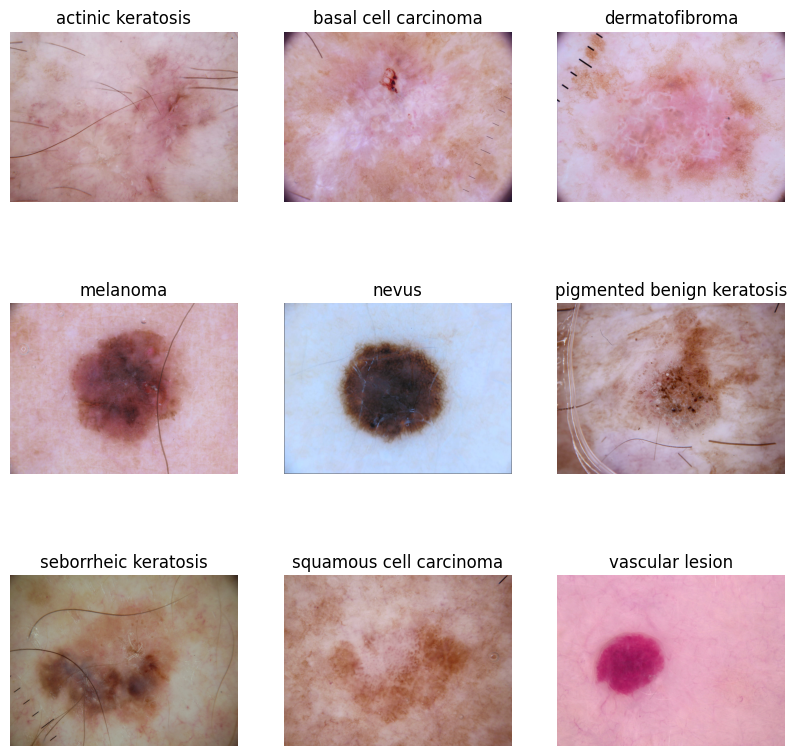

In [13]:
# visualize the data
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis("off")

### Create train and test datasets

In [14]:
# defines appropriate number of processes that are free for working.
AUTOTUNE = tf.data.experimental.AUTOTUNE
# keeps the images in memory after they're loaded off disk during the first epoch.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# overlaps data preprocessing and model execution while training.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build the Model

In [15]:
model = Sequential()
#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   

# Conv 1
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
# Maxpool1
model.add(MaxPool2D(pool_size=(2,2)))
# Conv 2
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
# Maxpool2
model.add(MaxPool2D(pool_size=(2,2)))
# Conv 3
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
# Maxpool3
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout layer 50%
# model.add(Dropout(0.5))
# Flatten Layer
model.add(Flatten())
# Dense Layer
model.add(Dense(128,activation='relu'))
# Dropout layer 25% 
# model.add(Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [16]:
#Compile the Model
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
# checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# train the model
epochs = 30
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/30
56/56 [==============================] - 11s 37ms/step - loss: 2.0779 - accuracy: 0.2070 - val_loss: 1.9257 - val_accuracy: 0.3065
Epoch 2/30
56/56 [==============================] - 1s 11ms/step - loss: 1.8260 - accuracy: 0.3287 - val_loss: 1.6189 - val_accuracy: 0.4653
Epoch 3/30
56/56 [==============================] - 1s 11ms/step - loss: 1.5963 - accuracy: 0.4286 - val_loss: 1.5395 - val_accuracy: 0.4765
Epoch 4/30
56/56 [==============================] - 1s 11ms/step - loss: 1.4362 - accuracy: 0.4805 - val_loss: 1.4697 - val_accuracy: 0.4810
Epoch 5/30
56/56 [==============================] - 1s 11ms/step - loss: 1.3225 - accuracy: 0.5279 - val_loss: 1.4702 - val_accuracy: 0.4877
Epoch 6/30
56/56 [==============================] - 1s 12ms/step - loss: 1.3227 - accuracy: 0.5251 - val_loss: 1.4871 - val_accuracy: 0.4877
Epoch 7/30
56/56 [==============================] - 1s 11ms/step - loss: 1.1909 - accuracy: 0.5698 - val_loss: 1.4528 - val_accuracy: 0.5123
Epoch 8/30
5

Since it is a multi class classification problem we are using categorical cross entropy as the loss function. Also, using Adam as an optimizer.

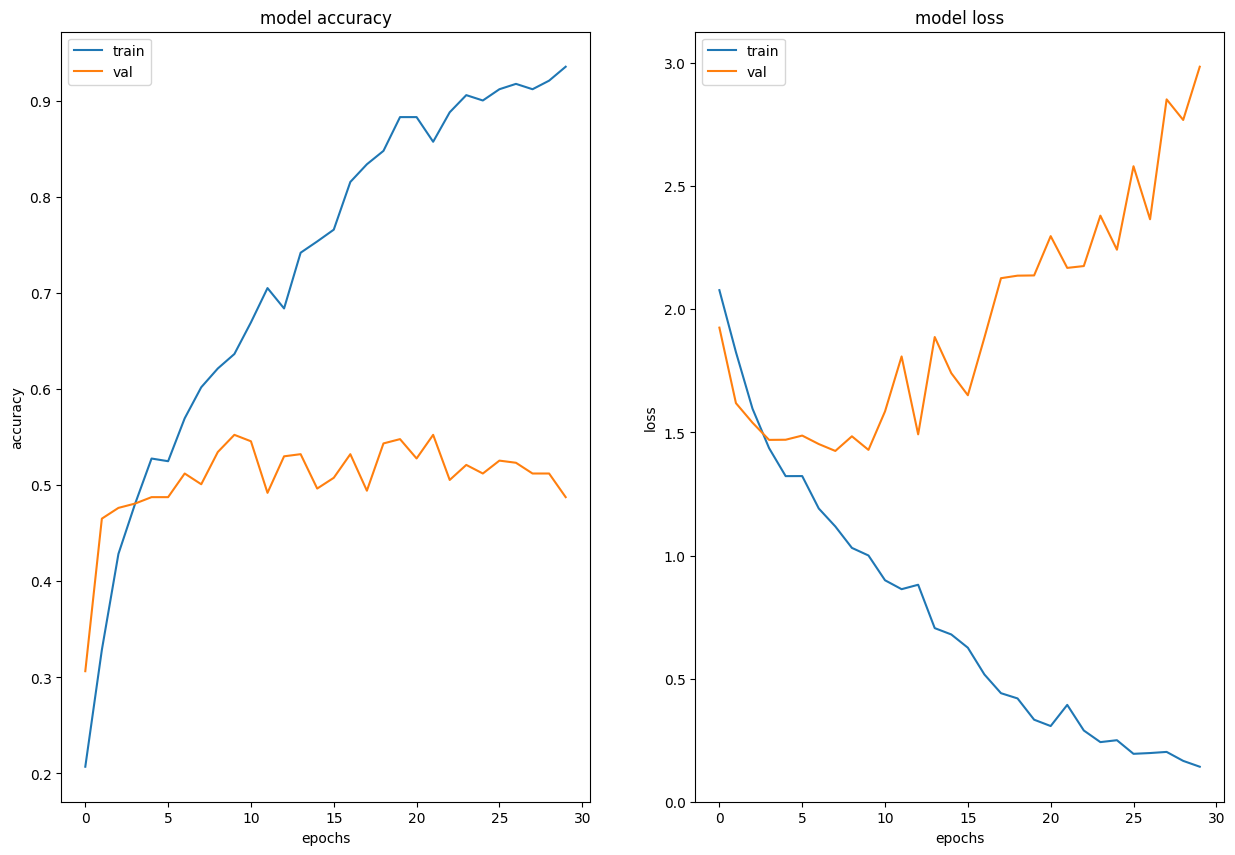

In [17]:
# Plot the training curves
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The train accuracy and test accuracy started having huge difference after 5 epochs. This could be a possible case of overfitting. Similarly the train loss and val loss shoe huge differnces after 10 epochs

Let's try to fit a better model by adding data augmentation in data preprocessing

In [18]:
# using data augmentation
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

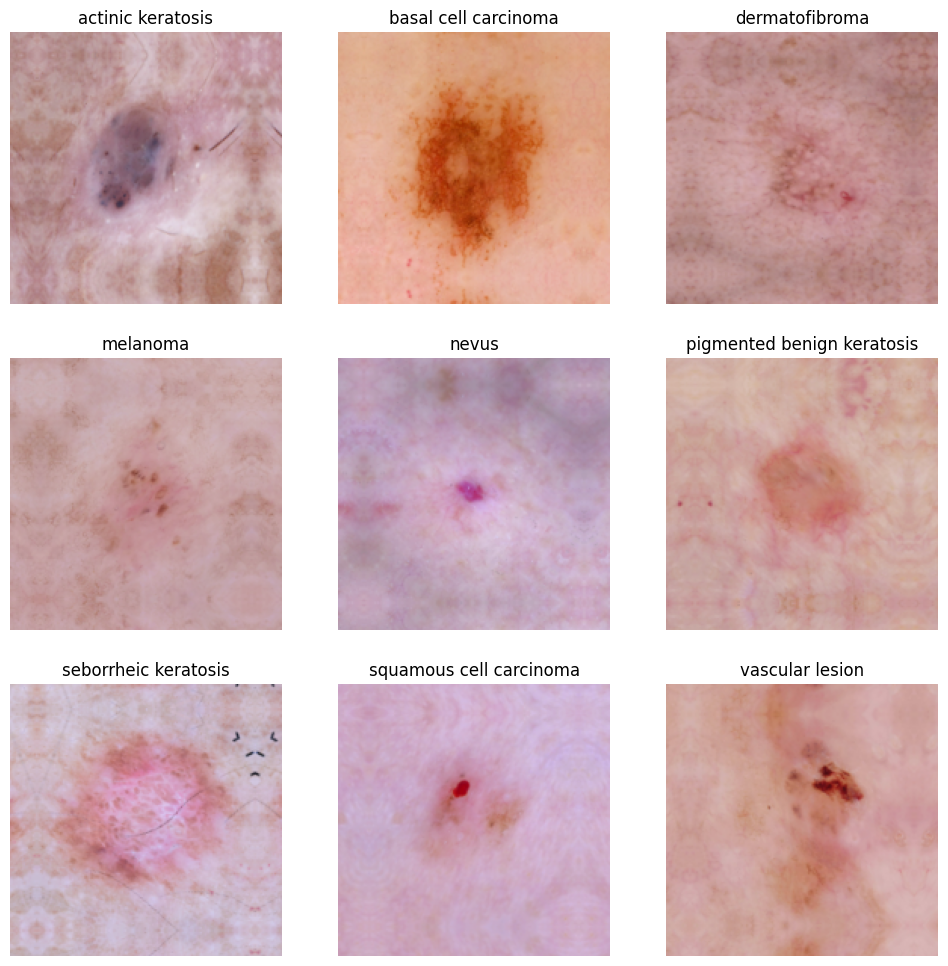

In [19]:
# visualize the augmented data
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

In [20]:
# build the cnn architecture
model = Sequential([ data_augument,
                        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
                    ])

# Conv 1
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
# Maxpool1
model.add(MaxPool2D(pool_size=(2,2)))
# Conv 2
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
# Maxpool2
model.add(MaxPool2D(pool_size=(2,2)))
# Conv 3
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
# Maxpool3
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout layer 50%
# model.add(Dropout(0.5))
# Flatten Layer
model.add(Flatten())
# Dense Layer
model.add(Dense(128,activation='relu'))
# Dropout layer 25% 
# model.add(Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [21]:
# compile the model
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# train the model
epochs = 30
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/30
56/56 [==============================] - 3s 15ms/step - loss: 1.9314 - accuracy: 0.3041 - val_loss: 1.8140 - val_accuracy: 0.3356
Epoch 2/30
56/56 [==============================] - 1s 13ms/step - loss: 1.5759 - accuracy: 0.4269 - val_loss: 1.5032 - val_accuracy: 0.4541
Epoch 3/30
56/56 [==============================] - 1s 12ms/step - loss: 1.4750 - accuracy: 0.4760 - val_loss: 1.5768 - val_accuracy: 0.4631
Epoch 4/30
56/56 [==============================] - 1s 12ms/step - loss: 1.4307 - accuracy: 0.4983 - val_loss: 1.4326 - val_accuracy: 0.4787
Epoch 5/30
56/56 [==============================] - 1s 12ms/step - loss: 1.3912 - accuracy: 0.5073 - val_loss: 1.3903 - val_accuracy: 0.5235
Epoch 6/30
56/56 [==============================] - 1s 12ms/step - loss: 1.3684 - accuracy: 0.5128 - val_loss: 1.4846 - val_accuracy: 0.5257
Epoch 7/30
56/56 [==============================] - 1s 12ms/step - loss: 1.2877 - accuracy: 0.5430 - val_loss: 1.4661 - val_accuracy: 0.4944
Epoch 8/30
56

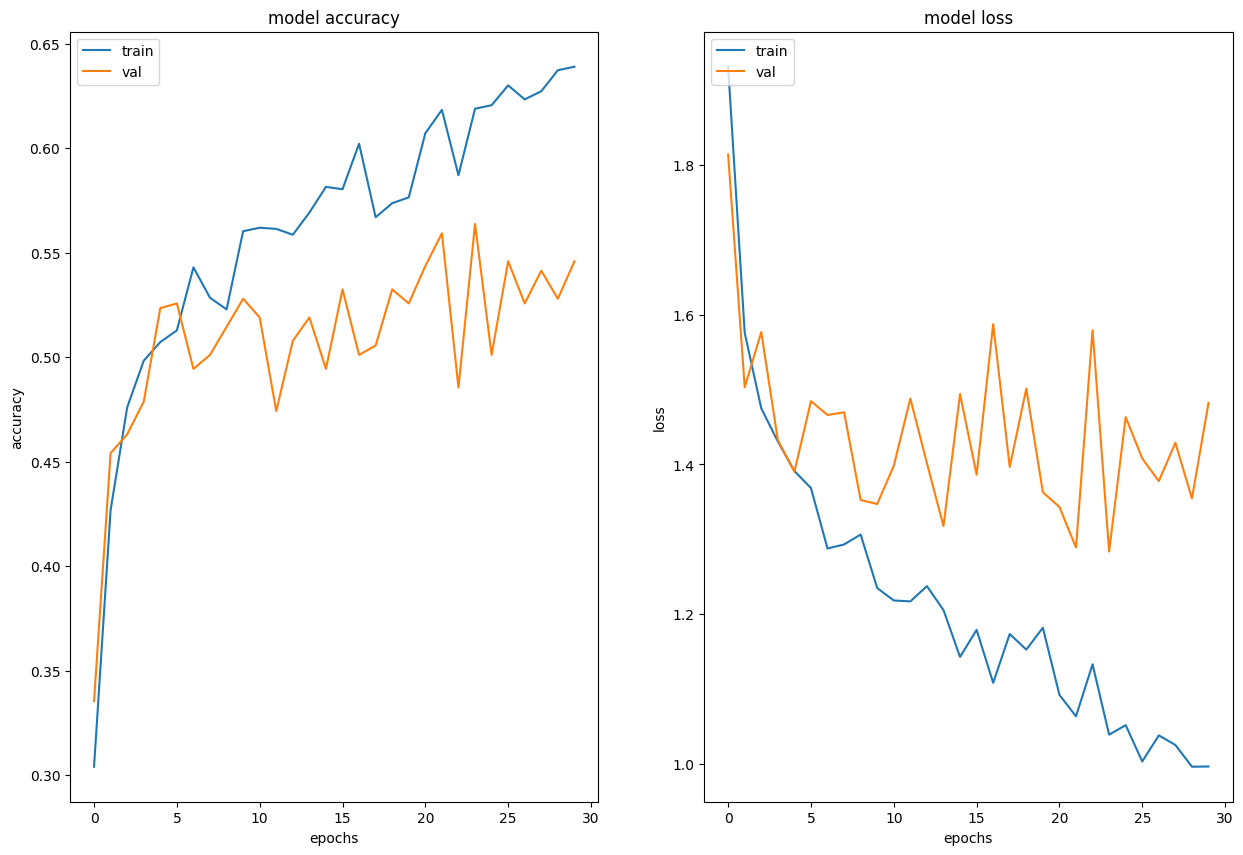

In [22]:
# Plot the training curves
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Still there is huge difference in the train accuracy, val accuracy. Similarly in train loss and val loss. Again there seems to be a overfitting condition

Let's try 
1. Augmentor to increase the total samples from all the classes
2. drop out layers to reduce overfitting 

### Augmentor to increase the sample size and handle class imbalance

In [23]:
# Augment more images for each class
for i in class_names:
    pth=str(data_dir_train)+"/"+i
    p = Augmentor.Pipeline(pth)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1DA99A6B0>: 100%|██████████| 500/500 [00:04<00:00, 123.62 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1DAA40820>: 100%|██████████| 500/500 [00:04<00:00, 116.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1901AD720>: 100%|██████████| 500/500 [00:04<00:00, 122.75 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7FA11A5E5C90>: 100%|██████████| 500/500 [00:17<00:00, 28.43 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1008x711 at 0x7FA1DA96E7A0>: 100%|██████████| 500/500 [00:15<00:00, 33.15 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1901506D0>: 100%|██████████| 500/500 [00:03<00:00, 125.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA11A5E7D60>: 100%|██████████| 500/500 [00:07<00:00, 65.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA190150D90>: 100%|██████████| 500/500 [00:04<00:00, 120.47 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1C805A620>: 100%|██████████| 500/500 [00:04<00:00, 122.30 Samples/s]


In [24]:
# data_dir_train1 = pathlib.Path("/content/drive/MyDrive/Upgrad/cnn_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [25]:
# check for class balance
classes=[]
count=[]
pct=[]

for d in os.listdir(data_dir_train):
    pth=pathlib.Path(os.path.join(data_dir_train,d))
    img_count=len(list(pth.glob('*.jpg')))
    pctg=round((img_count/image_count_train)*100,2)
    # print(f"{d}  : {img_count} | {pctg}%")
    classes.append(d)
    count.append(img_count)
    pct.append(pctg)

stats_df=pd.DataFrame(columns=['class','count','percentage'])
stats_df['class']=pd.Series(classes)
stats_df['count']=pd.Series(count)
stats_df['percentage']=pd.Series(pct)
classes=list(stats_df['class'])
stats_df

class  count  percentage
0           actinic keratosis    114        2.53
1        basal cell carcinoma    376        8.36
2              dermatofibroma     95        2.11
3                    melanoma    438        9.73
4                       nevus    357        7.93
5  pigmented benign keratosis    462       10.27
6        seborrheic keratosis     77        1.71
7     squamous cell carcinoma    181        4.02
8             vascular lesion    139        3.09

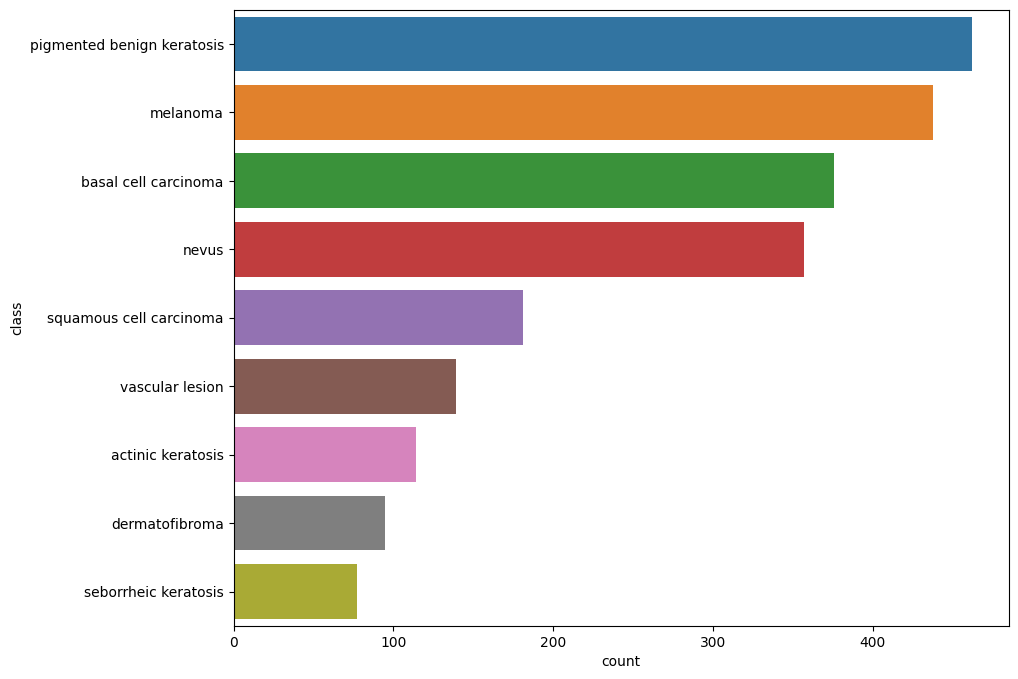

In [26]:
# plot the class balance
stats_df=stats_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x="count", y="class", data=stats_df, label="class")
plt.show()

In [27]:
# train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [28]:
# val dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [32]:
# build the cnn architecture
model = Sequential([ data_augument,
                        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
                    ])

# Conv 1
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
# Maxpool1
model.add(MaxPool2D(pool_size=(2,2)))
# Conv 2
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
# Maxpool2
model.add(MaxPool2D(pool_size=(2,2)))
# Conv 3
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
# Maxpool3
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout layer 50%
model.add(Dropout(0.5))
# Flatten Layer
model.add(Flatten())
# Dense Layer
model.add(Dense(128,activation='relu'))
# Dropout layer 25% 
model.add(Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

In [33]:
# Compile the Model
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# train the model
epochs = 30
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/30
169/169 [==============================] - 14s 64ms/step - loss: 1.8812 - accuracy: 0.2680 - val_loss: 1.6432 - val_accuracy: 0.3682
Epoch 2/30
169/169 [==============================] - 11s 63ms/step - loss: 1.5820 - accuracy: 0.3999 - val_loss: 1.5052 - val_accuracy: 0.4009
Epoch 3/30
169/169 [==============================] - 11s 62ms/step - loss: 1.4862 - accuracy: 0.4373 - val_loss: 1.3893 - val_accuracy: 0.4633
Epoch 4/30
169/169 [==============================] - 11s 62ms/step - loss: 1.4102 - accuracy: 0.4553 - val_loss: 1.5777 - val_accuracy: 0.3979
Epoch 5/30
169/169 [==============================] - 11s 62ms/step - loss: 1.3930 - accuracy: 0.4674 - val_loss: 1.4289 - val_accuracy: 0.4469
Epoch 6/30
169/169 [==============================] - 11s 63ms/step - loss: 1.3848 - accuracy: 0.4744 - val_loss: 1.4054 - val_accuracy: 0.4529
Epoch 7/30
169/169 [==============================] - 11s 62ms/step - loss: 1.3334 - accuracy: 0.4850 - val_loss: 1.3935 - val_accuracy:

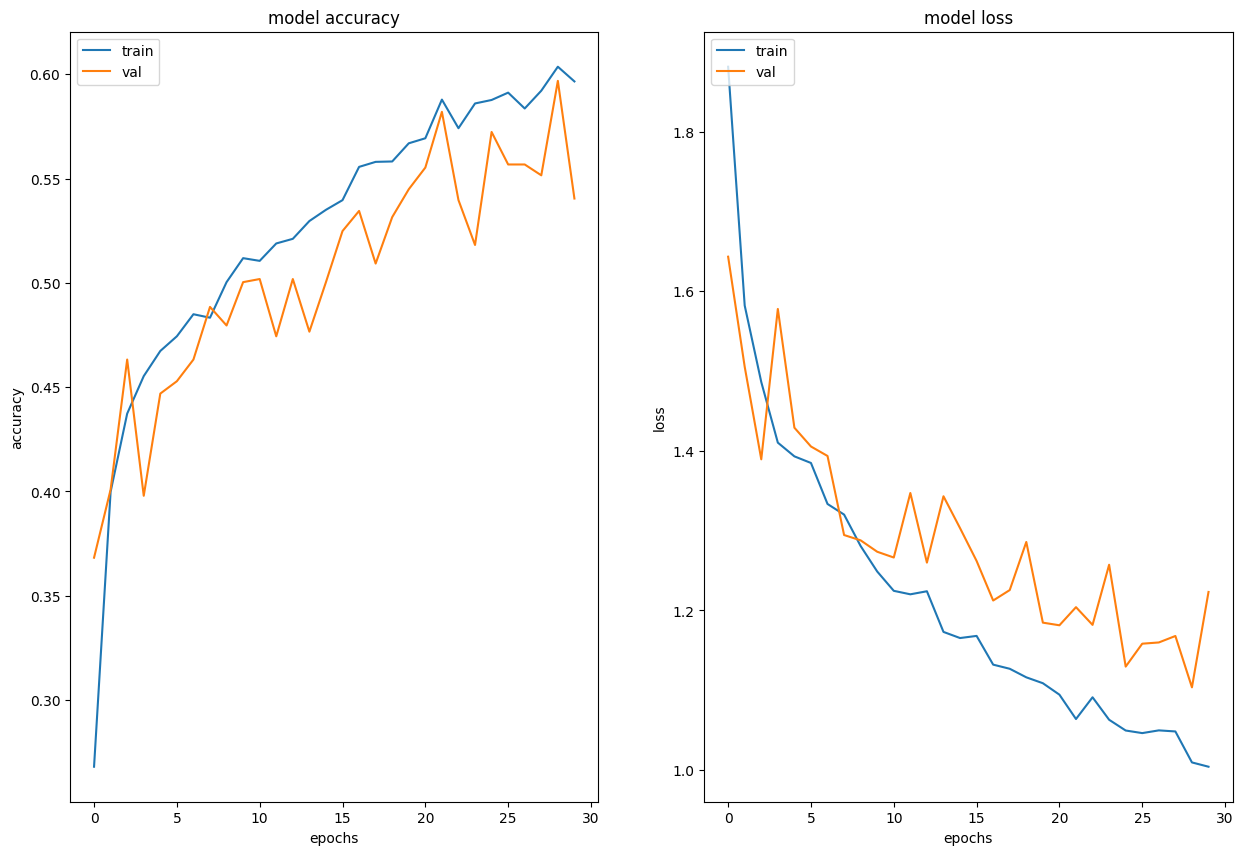

In [34]:
# Plot the training curves
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

After adding more images with Augmentor, dense layers the train accuracy, test accuracy are closer. There is an improvement in accuracy as well as reduction in overfitting

**Conclusion**:   
When the CNN was trained on the images the accuracy of the train phase was low. At the same time there was huge difference in train and val accuracy. After implementing transformations, Augmentor and dropout the train accuracy improved and also the overfitting is reduced.